# Rolling Planning mit Lateness (Tardiness + Earliness)

In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from configs.path_manager import get_path
from models import *

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 15 # 15 min

In [4]:
#db.close()
#db.connect()
#Schedule.drop_table()
#db.create_tables([Schedule])

#JobOperation.drop_table()
#db.create_tables([JobOperation])

#db.close()

## Laden des fertigen Datensatzes (60 Tage Ankunft)

In [5]:
# Jobs
df_jobs_times = Job.get_dataframe(version="base")
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*60]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,base
1,J25-0001,6,129,1440,2338,open,base
2,J25-0002,0,198,1440,3744,open,base
3,J25-0003,2,243,1440,3379,open,base
4,J25-0004,3,287,1440,4856,open,base
...,...,...,...,...,...,...,...
1188,J25-1188,8,85975,86400,88866,open,base
1189,J25-1189,1,86001,86400,88375,open,base
1190,J25-1190,5,86033,86400,87868,open,base
1191,J25-1191,1,86084,86400,88251,open,base


In [6]:
# Job.add_jobs_from_dataframe(df_jobs_times, version="lateness", status="open")
Job.clone_jobs(referenced_version="base", new_version="lateness")

✅ 7250 Jobs von Version 'base' nach Version 'lateness' kopiert.


In [7]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [8]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

In [9]:
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
11925,J25-1192,3,5,M08,52
11926,J25-1192,3,6,M07,85
11927,J25-1192,3,7,M03,98
11928,J25-1192,3,8,M09,22


In [10]:
JSSP_LIVE.add_from_dataframe(df_jssp, version="lateness", status="open")

✅ 11930 JSSP_LIVE-Einträge (Version 'lateness', Status 'open') wurden hinzugefügt oder aktualisiert.


In [11]:
df_jssp_live = JSSP_LIVE.get_dataframe(version="lateness")
df_jssp_live

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,8,M00,0,1556.31,1646.47,76.0,lateness,open
1,J25-0000,8,M01,1,1830.12,1905.73,69.0,lateness,open
2,J25-0000,8,M03,2,2323.18,2413.80,76.0,lateness,open
3,J25-0000,8,M05,3,2459.21,2526.24,51.0,lateness,open
4,J25-0000,8,M02,4,2561.53,2644.85,85.0,lateness,open
...,...,...,...,...,...,...,...,...,...
11925,J25-1192,3,M08,5,NaN,NaN,52.0,lateness,open
11926,J25-1192,3,M07,6,NaN,NaN,85.0,lateness,open
11927,J25-1192,3,M03,7,NaN,NaN,98.0,lateness,open
11928,J25-1192,3,M09,8,NaN,NaN,22.0,lateness,open


### Params

In [12]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


> Tag 0 wird nicht ausgeführt

## Tag 1 (init. Tag - kein Rescheduling)

In [13]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [14]:
# alle aktuelle "offenen" Jobs
df_job_times_curr = Job.get_dataframe(version="base", arrival_time_max=day_start, status="open")
df_job_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,base
1,J25-0001,6,129,1440,2338,open,base
2,J25-0002,0,198,1440,3744,open,base
3,J25-0003,2,243,1440,3379,open,base
4,J25-0004,3,287,1440,4856,open,base
5,J25-0005,1,498,1440,3106,open,base
6,J25-0006,9,790,1440,3539,open,base
7,J25-0007,5,925,1440,2929,open,base
8,J25-0008,4,988,1440,3541,open,base
9,J25-0009,7,1004,1440,3578,open,base


In [15]:
#  JSSP zu allen "offenen" Jobs
df_jssp_temp = get_jssp_for_jobs(df_job_times_curr, df_routings)
df_jssp_temp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


In [16]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JSSP_LIVE.get_dataframe(version="lateness", jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


### A) Scheduling

In [17]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(df_jssp_curr, df_job_times_curr, 
                                                                         schedule_start = day_start, w_t=5,
                                                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.04 Sekunden


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0005,1,0,M00,498,3106,1440,43,1483,-1623,0,1623
1,J25-0007,5,0,M02,925,2929,1440,84,1524,-1405,0,1405
2,J25-0013,3,0,M01,1192,2567,1440,81,1521,-1046,0,1046
3,J25-0011,1,0,M00,1030,3210,1483,43,1526,-1684,0,1684
4,J25-0001,6,0,M01,129,2338,1521,46,1567,-771,0,771
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0009,7,9,M03,1004,3578,3499,79,3578,0,0,0
156,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
157,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
158,J25-0012,2,9,M04,1103,4385,4352,33,4385,0,0,0


In [18]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              16
0 - 60          0
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


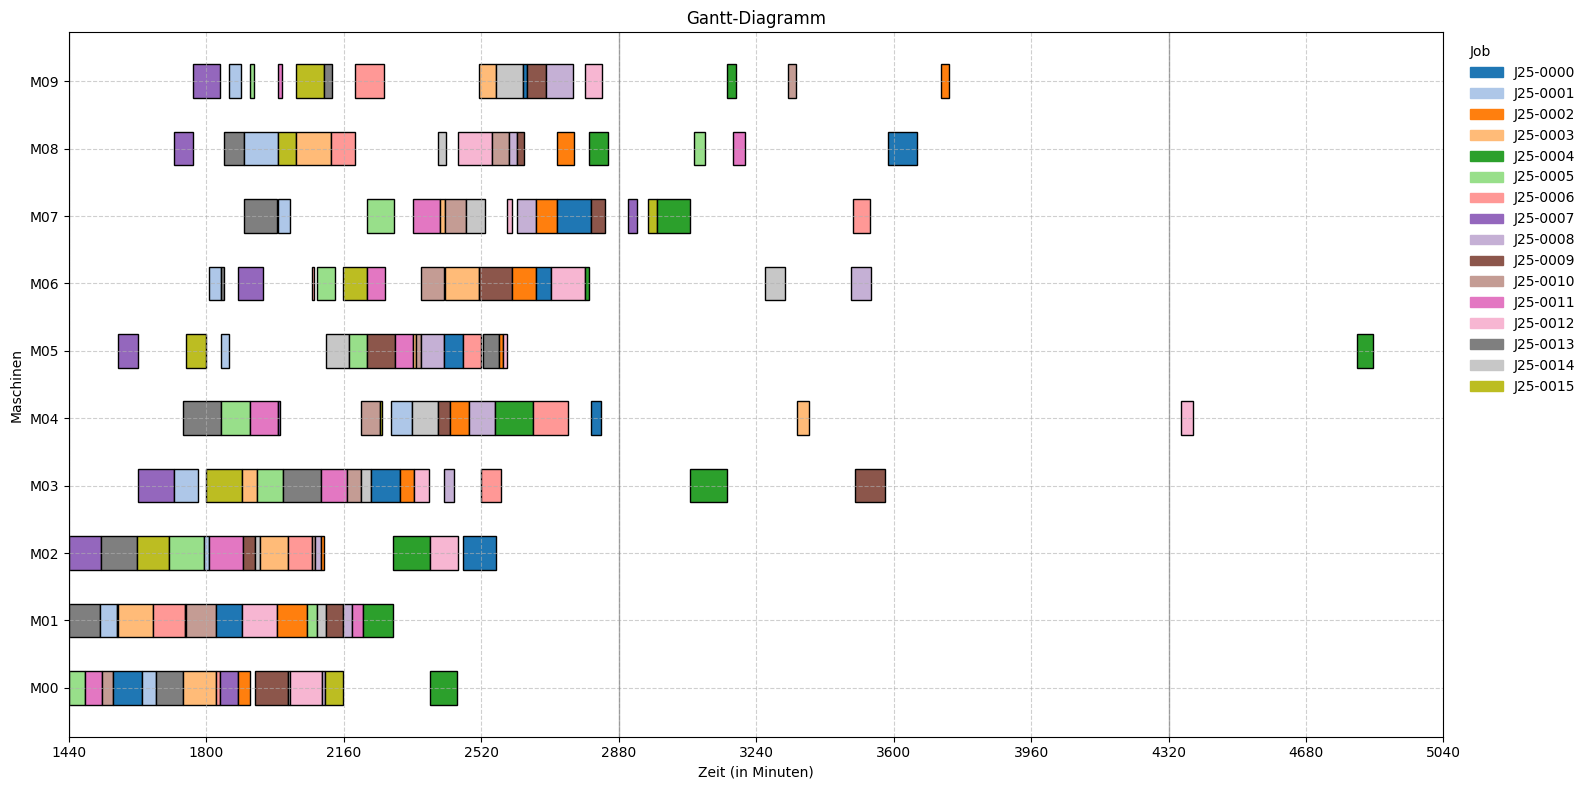

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [20]:
df_schedule

,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0005,1,0,M00,498,3106,1440,43,1483,-1623,0,1623
1,J25-0007,5,0,M02,925,2929,1440,84,1524,-1405,0,1405
2,J25-0013,3,0,M01,1192,2567,1440,81,1521,-1046,0,1046
3,J25-0011,1,0,M00,1030,3210,1483,43,1526,-1684,0,1684
4,J25-0001,6,0,M01,129,2338,1521,46,1567,-771,0,771
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0009,7,9,M03,1004,3578,3499,79,3578,0,0,0
156,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
157,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
158,J25-0012,2,9,M04,1103,4385,4352,33,4385,0,0,0


In [21]:
json_schedule = df_schedule.to_dict(orient='records')

Schedule.add_schedule(
    data=json_schedule,
    date=day_numb,
    version="lateness"
)

✅ Schedule hinzugefügt (Version=lateness, Date=1)


### C) Simulation

In [22]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:41:02] Job J25-0005 finished on M00 (after 41 minutes 02 seconds)
[Day 1 00:43:00] Job J25-0011 started on M00
[Day 1 01:17:30] Job J25-0011 finished on M00 (after 34 minutes 31 seconds)
[Day 1 01:18:49] Job J25-0007 finished on M02 (after 78 minutes 49 seconds)
[Day 1 01:26:00] Job J25-0010 started on M00
[Day 1 01:39:30] Job J25-0013 finished on M01 (after 99 minutes 30 seconds)
[Day 1 01:39:30] Job J25-0001 started on M01
[Day 1 01:39:30] Job J25-0013 started on M02
[Day 1 01:58:31] Job J25-0010 finished on M00 (after 32 minutes 31 seconds)
[Day 1 01:58:31] Job J25-0000 started on M00
[Day 1 02:15:58] Job J25-0001 finished on M01 (after 36 minutes 29 seconds)
[Day 1 02:15:58] Job J25-0007 started on M01
[Day 1 02:18:39] Job J25-0007 finished on M01 (after 02 minutes 41 seconds)
[Day 1 02:18:39] Job J25-0003 started on M01
[Day 1 02:18:39] J

In [23]:
df_execution 

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1558.52,60.74,1619.26
1,J25-0000,8,1,M01,79,1854.70,64.48,1919.18
2,J25-0000,8,2,M03,79,2283.09,77.51,2360.60
3,J25-0000,8,3,M05,79,2445.52,53.91,2499.43
4,J25-0000,8,4,M02,79,2520.67,82.96,2603.63
...,...,...,...,...,...,...,...,...
138,J25-0015,5,4,M08,1436,2000.38,30.88,2031.26
139,J25-0015,5,5,M09,1436,2036.00,66.67,2102.67
140,J25-0015,5,6,M00,1436,2143.30,38.40,2181.70
141,J25-0015,5,7,M06,1436,2200.33,93.75,2294.08


In [24]:
df_ops_finished = df_execution[df_execution.End < day_end]
df_ops_finished

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1558.52,60.74,1619.26
1,J25-0000,8,1,M01,79,1854.70,64.48,1919.18
2,J25-0000,8,2,M03,79,2283.09,77.51,2360.60
3,J25-0000,8,3,M05,79,2445.52,53.91,2499.43
4,J25-0000,8,4,M02,79,2520.67,82.96,2603.63
...,...,...,...,...,...,...,...,...
138,J25-0015,5,4,M08,1436,2000.38,30.88,2031.26
139,J25-0015,5,5,M09,1436,2036.00,66.67,2102.67
140,J25-0015,5,6,M00,1436,2143.30,38.40,2181.70
141,J25-0015,5,7,M06,1436,2200.33,93.75,2294.08


In [25]:
JSSP_LIVE.add_from_dataframe(df_ops_finished, version="lateness", status="finished")

✅ 139 JSSP_LIVE-Einträge (Version 'lateness', Status 'finished') wurden hinzugefügt oder aktualisiert.


In [27]:
JSSP_LIVE.update_closed_jobs_from_operations(version="lateness")

✅ 2 Job(s) wurden auf 'closed' gesetzt (Version 'lateness').


['J25-0001', 'J25-0013']

In [28]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

In [29]:
df_ops_in_progess = df_execution[df_execution.End >= day_end]
df_ops_in_progess

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
8,J25-0000,8,8,M04,79,2863.78,43.46,2907.24
42,J25-0004,3,5,M08,287,2847.11,37.58,2884.69
87,J25-0009,7,8,M07,1004,2863.78,32.03,2895.81
114,J25-0012,2,8,M09,1103,2833.22,50.28,2883.50


In [30]:
JSSP_LIVE.add_from_dataframe(df_ops_in_progess, version="lateness", status="in progress")

✅ 4 JSSP_LIVE-Einträge (Version 'lateness', Status 'in progress') wurden hinzugefügt oder aktualisiert.


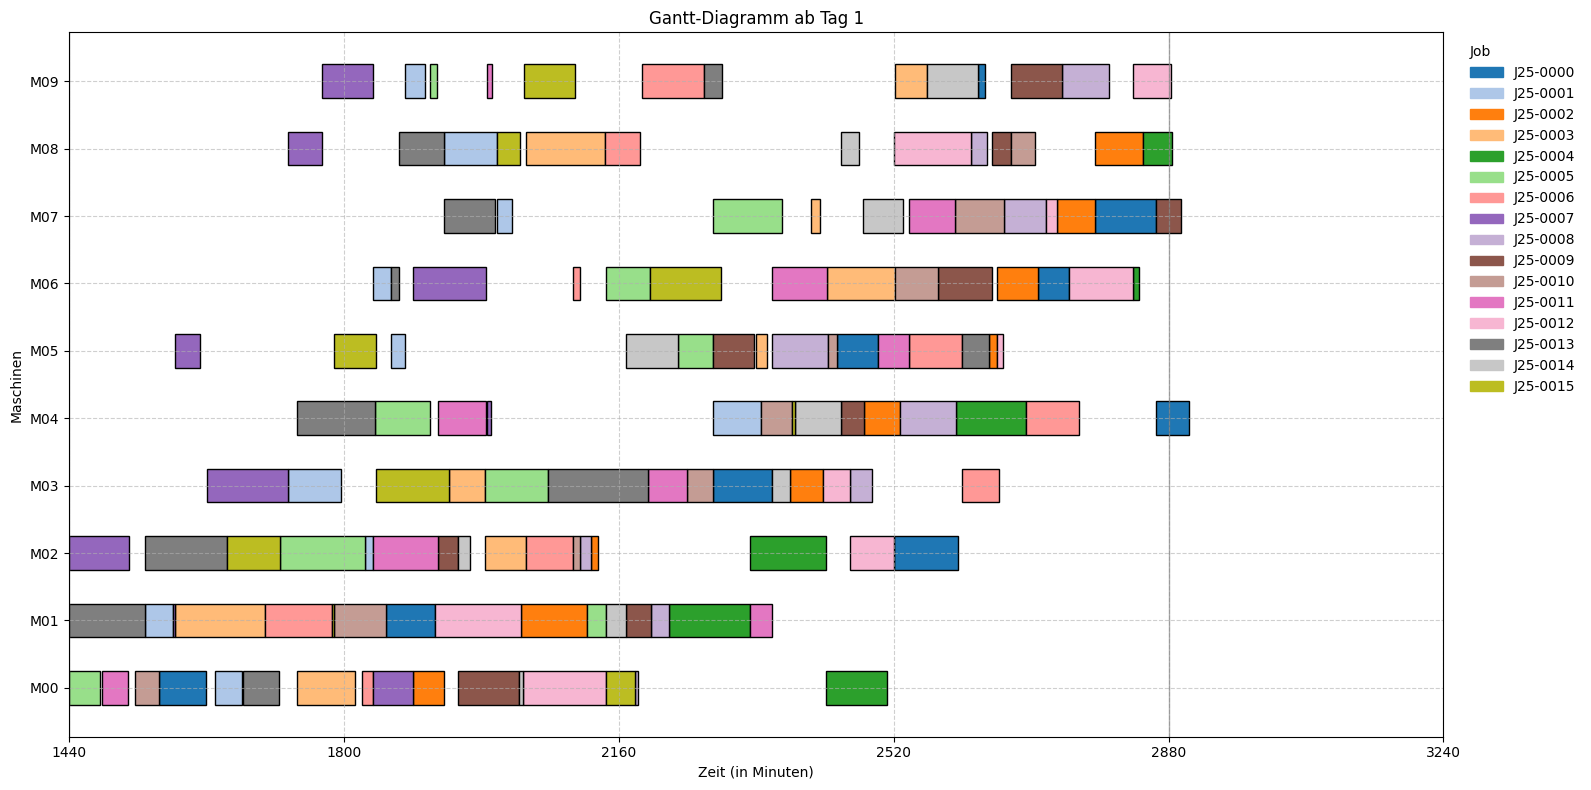

In [33]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### Test

In [39]:
df_plan_undone_v0 = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone_v0.sort_values(by="Job")

,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
13,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
14,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
9,J25-0003,2,9,M04,243,3379,3346,33,3379,0,0,0
16,J25-0004,3,9,M05,287,4856,4813,43,4856,0,0,0
2,J25-0004,3,6,M07,287,4856,2981,85,3066,-1790,0,1790
3,J25-0004,3,7,M03,287,4856,3066,98,3164,-1692,0,1692
5,J25-0004,3,8,M09,287,4856,3164,22,3186,-1670,0,1670
4,J25-0005,1,9,M08,498,3106,3076,30,3106,0,0,0
11,J25-0006,9,9,M07,790,3539,3494,45,3539,0,0,0
0,J25-0007,5,9,M07,925,2929,2904,25,2929,0,0,0


In [42]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
unique_jobs = df_schedule.Job.unique().tolist()
df_plan_undone  = JSSP_LIVE.get_dataframe(version="lateness", jobs=unique_jobs, status="open")
df_plan_undone.sort_values(by="Job")

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,8,M08,9,None,None,74.0,lateness,open
1,J25-0002,0,M09,9,None,None,21.0,lateness,open
2,J25-0003,2,M04,9,None,None,33.0,lateness,open
3,J25-0004,3,M07,6,None,None,85.0,lateness,open
4,J25-0004,3,M03,7,None,None,98.0,lateness,open
5,J25-0004,3,M09,8,None,None,22.0,lateness,open
6,J25-0004,3,M05,9,None,None,43.0,lateness,open
7,J25-0005,1,M08,9,None,None,30.0,lateness,open
8,J25-0006,9,M07,9,None,None,45.0,lateness,open
9,J25-0007,5,M07,9,None,None,25.0,lateness,open


In [34]:
undone_numb = len(df_plan_undone)
print(f"Number of undone operations: {undone_numb}")

Number of undone operations: 17
